In [3]:
import sys
sys.path.append("../")
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scripts.theodolite_utils as theodo_u
import scripts.theodolite_plot_function as theodo_p
import scripts.groundtruth_utils as theodo_g
import datetime as dt
from numpy import linalg
from tqdm import tqdm
import importlib
theodo_u = importlib.reload(theodo_u)
theodo_p = importlib.reload(theodo_p)

# Analysis with all data

In [4]:
theodo_u = importlib.reload(theodo_u)

# Data we want to use
path = [
    "../data/20220224/",
    "../data/20220307/",
    "../data/20220312/",
    "../data/20220314/",
    "../data/20220316/",
    "../data/20220331-1/",
    "../data/20220331-2/",
    "../data/20220427-1/",
    "../data/20220427-2/",
    "../data/20220505-1/",
    "../data/20220505-2/",
    "../data/20220513-1/",
    "../data/20220513-2/",
    "../data/20220513-3/",
    "../data/20220513-4/",
    "../data/20220513-5/",
    "../data/20220513-6/",
    "../data/20220523-1/",
    "../data/20220523-2/",
    "../data/20220523-3/",
    "../data/20220523-4/",
    "../data/20220525-1/",
    "../data/20220525-2/",
    "../data/20220622-1/",
    "../data/20220622-2/",
    "../data/20220630-1/",
    "../data/20220630-2/",
    "../data/20220711-1/",
    "../data/20220711-2/",
    "../data/20220715-1/",
    "../data/20220715-2/",
    "../data/20220715-3/",
    "../data/20220715-4/",
    "../data/20220717-1/",
    "../data/20220717-2/",
    "../data/20220717-3/",
    "../data/20220717-4/",
    "../data/20220717-5/",
    "../data/20220910-1/",
    "../data/20220910-2/",
    "../data/20220910-3/",
    "../data/20220910-4/",
    "../data/20220910-5/",
    "../data/20220910-6/",
    "../data/20220910-7/",
    "../data/20220910-8/",
    "../data/20220910-9/",
    "../data/20221103-1/",
    "../data/20221103-2/",
    "../data/20221103-3/",
    "../data/20221109-1/",
    "../data/20221109-2/",
    "../data/20221109-3/",
    "../data/20221110/",
    "../data/20221116-1/",
    "../data/20221123/",
    "../data/20221124/",
    "../data/20221129-1/",
    "../data/20221129-2/",
    "../data/20221129-3/",
    "../data/20221129-4/",
    "../data/20221129-5/",
    "../data/20221205-1/",
    "../data/20221205-2/",
    "../data/20221205-3/"
]

# Sub path to the file of raw_data in each repository
sub_path = "uncertainty/raw_data/"

## Values of corrections
## Range
random_noise_range = [0, 0.004/2, 2]   ## Mean, sigma, ppm,  4mm + 2ppm (2 sigma)  ISO17123-3
## Angles
random_noise_angle = [0, 0.000024241/5*4/2]    # Mean, sigma, 5"=0.000024241 precision datasheet  (2 sigma)  ISO17123-3
## Tilt compensator
random_noise_tilt = [0, 0.000002424/2]    # Mean, sigma, 0.5"=0.000002424 precision datasheet  (2 sigma)  ISO17123-3
## Weather
weather_data_path = "../data/weather_2022/Quebec/"
data_weather = np.array(theodo_u.read_weather_data(weather_data_path+"data_sorted_2022.txt"))
## MC number sample
num_samples = 10

## Choice of noise model  # Tilt noise, Atmospheric correction, extrinsic calibration, Weather corrections, Time synchronization # 1: Activate, 0:Disable
model_chosen_list = [
    [0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0],
    [0, 1, 0, 0, 0],
    [0, 0, 1, 0, 0],
    [1, 1, 1, 0, 0]
]

In [ ]:
theodo_g = importlib.reload(theodo_g)
theodo_u = importlib.reload(theodo_u)
# Compute covariance of all measurements for the dataset selected and model chosen

Data_uncertainty_total = []
for model_chosen in model_chosen_list:
    print("Model chosen: ", model_chosen)
    Data_uncertainty = []
    for file_path in path:
        print(file_path)
        P1 = theodo_u.read_raw_data_uncertainty(file_path+sub_path+"prism1.csv")
        P2 = theodo_u.read_raw_data_uncertainty(file_path+sub_path+"prism2.csv")
        P3 = theodo_u.read_raw_data_uncertainty(file_path+sub_path+"prism3.csv")

        ## Number of rigid transforms to apply the uncertainty
        path_file_GCP = "total_stations/GCP.txt"
        frame_chosen, T_1_corrected, T_2_corrected, T_3_corrected = theodo_g.extrinsic_calibration_noise(file_path+path_file_GCP, random_noise_range, random_noise_angle, random_noise_tilt, num_samples)
        ## Read Extrinsic results for RTS
        ## Estimated extrinsic calibration uncertainty
        _, _, _, Tf_1, Tf_2, Tf_3 = theodo_u.read_marker_file(file_path+path_file_GCP, 1, 1)

        for i,j,k in zip(P1,P2,P3):
            mu_raw_data, _,cov_matrix_simulated = theodo_g.MC_raw_data(num_samples, i[1], random_noise_range, i[2], i[3], random_noise_angle, random_noise_tilt, Tf_1, T_1_corrected, data_weather, i[0], model_chosen)
            # Time, points in cartesian frame of RTS 1, Covariance matrix, raw range, raw azimuth, raw elevation
            Data_uncertainty.append([i[0],mu_raw_data,cov_matrix_simulated, i[1], i[2], i[3]])
            mu_raw_data, _,cov_matrix_simulated = theodo_g.MC_raw_data(num_samples, j[1], random_noise_range, j[2], j[3], random_noise_angle, random_noise_tilt, Tf_1, T_1_corrected, data_weather, j[0], model_chosen)
            # Time, points in cartesian frame of RTS 1, Covariance matrix, raw range, raw azimuth, raw elevation
            Data_uncertainty.append([j[0],mu_raw_data,cov_matrix_simulated, j[1], j[2], j[3]])
            mu_raw_data, _,cov_matrix_simulated = theodo_g.MC_raw_data(num_samples, k[1], random_noise_range, k[2], k[3], random_noise_angle, random_noise_tilt, Tf_1, T_1_corrected, data_weather, k[0], model_chosen)
            # Time, points in cartesian frame of RTS 1, Covariance matrix, raw range, raw azimuth, raw elevation
            Data_uncertainty.append([k[0],mu_raw_data,cov_matrix_simulated, k[1], k[2], k[3]])

    Data_uncertainty_total.append(Data_uncertainty)
Data_uncertainty_total = np.array(Data_uncertainty_total)

In [ ]:
## Frobenius norm for all data according to the model chosen and the range linked
theodo_g = importlib.reload(theodo_g)

Parameter_RTS_total = []    # Here the parameters linked to the metric (range for instance)
Distance_F_total = []
for i in Data_uncertainty_total[1:]:
    Distance_F = []
    Parameter_RTS = []
    for j,k in zip(i,Data_uncertainty_total[0]):
        Distance_F.append(np.sqrt(theodo_u.Frobenius_norm(j[2], k[2])))
        Parameter_RTS.append(j[3])
    Distance_F_total.append(Distance_F)
    Parameter_RTS_total.append(Parameter_RTS)

In [ ]:
## Labeling the figure
data = Distance_F_total
fig, ax = plt.subplots()
ax.boxplot(data, showfliers=False, notch=False)
ax.set_xticklabels(['RTS + Tilt', 'RTS + \nAtmospheric', 'RTS + \nExtrinsic calib', 'RTS + All'])
plt.show()

In [ ]:
## Sort results according to the range of measurements
theodo_g = importlib.reload(theodo_g)

Distance_F_total_sorted = []
for i,j in zip(Distance_F_total, Parameter_RTS_total):
    Dist_0_25 = []
    Dist_25_75 = []
    Dist_75_125 = []
    Dist_125_200 = []
    Dist_200 = []
    for k,l in zip(i,j):
        if 0 <= l < 25:                 # Between 0 and 25m
            Dist_0_25.append(k*1000)
        if 25 <= l < 75:                # Between 25 and 75m
            Dist_25_75.append(k*1000)
        if 75 <= l < 125:               # Between 75 and 125m
            Dist_75_125.append(k*1000)
        if 125 <= l < 200:              # Between 125 and 200m
            Dist_125_200.append(k*1000)
        if 200 <= l:                    # Between 200 and more
            Dist_200.append(k*1000)
    Distance_F_total_sorted.append([Dist_0_25, Dist_25_75, Dist_75_125, Dist_125_200, Dist_200])

In [ ]:
## Inserting datas into the figure

data = []
for i in Distance_F_total_sorted:
    for j in i:
        data.append(j)
max_value = np.max(data[-1])

fig, ax = plt.subplots()
box = ax.boxplot(data, showfliers=False, notch=False, patch_artist=True)
ax.set_xticklabels(['', '', 'RTS + Tilt', '', '',
                    '', '', 'RTS + \nAtmospheric', '', '',
                    '', '', 'RTS + \nExtrinsic calib', '', '',
                    '', '', 'RTS + All', '', '',])

colors = ['cyan', 'lightblue', 'lightgreen', 'tan', 'pink',
          'cyan', 'lightblue', 'lightgreen', 'tan', 'pink',
          'cyan', 'lightblue', 'lightgreen', 'tan', 'pink',
          'cyan', 'lightblue', 'lightgreen', 'tan', 'pink']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

ax.vlines(5.5,0,max_value, linestyles='dashed', color="black")
ax.vlines(10.5,0,max_value, linestyles='dashed', color="black")
ax.vlines(15.5,0,max_value, linestyles='dashed', color="black")

ax.set_xlabel("\nCorrection used as comparison")
ax.set_ylabel("Square Frobenius norm [mm]")
ax.set_yscale('log')
ax.legend(handles=[box["boxes"][0], box["boxes"][1], box["boxes"][2], box["boxes"][3], box["boxes"][4]],
          labels =['0 to 25m', '25 to 75m', '75 to 125m', '125 to 200m', 'More than 200m'],
          loc='upper center', bbox_to_anchor=(0.5, 1.18), ncol=3)
plt.tight_layout()
plt.savefig("../figs/uncertainty/Frobenius_norm.png", bbox_inches="tight")
plt.show()

In [5]:
## Creating a list for all the data (static points)
#script theodolite utils
theodo_u = importlib.reload(theodo_u)
theodo_g = importlib.reload(theodo_g)

#Weather conditions directory files
weather_data_path = "../data/weather_2022/Quebec/"
data_weather = np.array(theodo_u.read_weather_data(weather_data_path+"data_sorted_2022.txt"))

#Interpolation for weather data with static points 
time_weather = data_weather[:, 0].astype(np.float64)

#Path for static points
sub_path = "uncertainty/static_raw_data/"

P_list=[]
id=0

for file_path in path :

    #3 Static points file path

    P1 = theodo_u.read_raw_data_uncertainty(file_path+sub_path+"prism1.csv")
    P2 = theodo_u.read_raw_data_uncertainty(file_path+sub_path+"prism2.csv")
    P3 = theodo_u.read_raw_data_uncertainty(file_path+sub_path+"prism3.csv")



    lambda_edm =  0.905  # In micro-meter
    noise_temp = [0, 1]
    noise_pressure = [0, 10]
    noise_humidity = [0, 2]
    Nominal_values = [1013.25, 20, 60]

    #Create a list of all informations for 3 prisms (time_stamp, distance, azimuth, elevation, temperature, humidity, pressure, weather, refractive index, atmospheric correction for the distance)
    for i in P1 :
        index, _ = theodo_u.findClosest(time_weather, i[0])
        temperature, humidity, pressure, weather = theodo_u.interpolation_weather_data(i[0], data_weather, index)
        Measured_values = [pressure, temperature, humidity] 
        D,nl,ppm = theodo_g.edm_noise(i[1],lambda_edm,Measured_values,Nominal_values,noise_temp,noise_pressure,noise_humidity,num_samples)
        nl_mean = np.mean(nl)
        ppm_mean = np.mean(ppm)
        ppm_mm = ppm_mean*i[1]*10**-3
        P_list.append([i[0],i[1],i[2],i[3],temperature,humidity,pressure,weather,nl_mean,ppm_mm,2,id]) 
        # P_list.append([i[0],i[1],i[2],i[3],temperature,humidity,pressure,weather,nl_mean,ppm_mean,2,id]) 
    for i in P2 :
        index, _ = theodo_u.findClosest(time_weather, i[0])
        temperature, humidity, pressure, weather = theodo_u.interpolation_weather_data(i[0], data_weather, index)
        Measured_values = [pressure, temperature, humidity] 
        D,nl,ppm = theodo_g.edm_noise(i[1],lambda_edm,Measured_values,Nominal_values,noise_temp,noise_pressure,noise_humidity,num_samples)
        nl_mean = np.mean(nl)
        ppm_mean = np.mean(ppm)
        ppm_mm = ppm_mean*i[1]*10**-3
        P_list.append([i[0],i[1],i[2],i[3],temperature,humidity,pressure,weather,nl_mean,ppm_mm,2,id]) 
        # P_list.append([i[0],i[1],i[2],i[3],temperature,humidity,pressure,weather,nl_mean,ppm_mean,2,id]) 
    for i in P3 :
        index, _ = theodo_u.findClosest(time_weather, i[0])
        temperature, humidity, pressure, weather = theodo_u.interpolation_weather_data(i[0], data_weather, index)
        Measured_values = [pressure, temperature, humidity] 
        D,nl,ppm = theodo_g.edm_noise(i[1],lambda_edm,Measured_values,Nominal_values,noise_temp,noise_pressure,noise_humidity,num_samples)
        nl_mean = np.mean(nl)
        ppm_mean = np.mean(ppm)
        ppm_mm = ppm_mean*i[1]*10**-3
        P_list.append([i[0],i[1],i[2],i[3],temperature,humidity,pressure,weather,nl_mean,ppm_mm,2,id]) 
        # P_list.append([i[0],i[1],i[2],i[3],temperature,humidity,pressure,weather,nl_mean,ppm_mean,2,id]) 
    id+=1


In [6]:
## Creating a Data Frame of the data
df = pd.DataFrame(data=P_list,columns=['time_stamp','distance','azimuth','elevation','temperature','humidity','pressure','weather condition','refractive index','distance correction','prism id','experiment id'])
# df = pd.DataFrame(data=P_list,columns=['time_stamp','distance','azimuth','elevation','temperature','humidity','pressure','weather condition','refractive index','ppm','prism id','experiment id'])
#Converting time_stamp in date time
df['date time'] = pd.to_datetime(df['time_stamp'],unit='s')

#Reassorting data from and export to txt
df = df[['experiment id','prism id','distance','distance correction','temperature','humidity','pressure','weather condition','refractive index','azimuth','elevation','time_stamp','date time',]]
# df = df[['experiment id','prism id','distance','ppm','temperature','humidity','pressure','weather condition','refractive index','azimuth','elevation','time_stamp','date time',]]
df.to_string("../data/weather_2022/Quebec/atmospheric_correction.txt")

In [ ]:
## Sort mean atmospheric values for each experiments
means = []
for i in range(0,len(path)):
    exp_df = df[df['experiment id'] == i]
    means.append([i,exp_df['weather condition'].iloc[0],exp_df['refractive index'].mean(axis = 0),exp_df['temperature'].mean(axis = 0),exp_df['humidity'].mean(axis = 0),exp_df['pressure'].mean(axis = 0)])

means_df = pd.DataFrame(data=means,columns=['experiment id','weather condition','refractive index','temperature','humidity','pressure'])
means_df = means_df.round({'experiment id':1,'weather condition':0,'refractive index':8,'temperature':2,'humidity':0,'pressure':0})
means_df = means_df.sort_values(by=['refractive index'])
# print(means_df.to_string())

means_df.to_string("../data/weather_2022/Quebec/mean_refractive_index.txt")

In [7]:
## Creating a Data Frame for impact of refractive index on distance
dist_df = df[['experiment id','prism id','distance','distance correction','refractive index','temperature','humidity','pressure','weather condition']]
# dist_df = df[['experiment id','prism id','distance','ppm','refractive index','temperature','humidity','pressure','weather condition']]
dist_df = dist_df.sort_values('experiment id')
# dist_df = dist_df.sort_values('refractive index')

dist_df.to_string("../data/weather_2022/Quebec/all_datas_refractive.txt")
# print(dist_df.to_string())

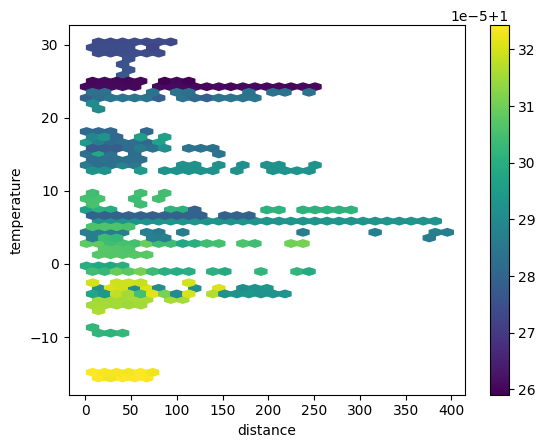

In [8]:
## Graph distance with temperature du to refractive index
ax = dist_df.plot.hexbin(x = 'distance',
                        y = 'temperature',
                        C = 'refractive index',
                        reduce_C_function=np.mean,
                        gridsize=(30,30),
                        cmap='viridis')



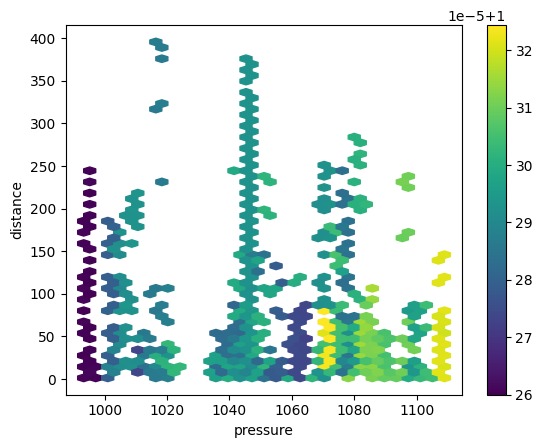

In [ ]:
## Graph distance with temperature du to refractive index
ax = dist_df.plot.hexbin(x = 'pressure',
                        y = 'distance',
                        C = 'refractive index',
                        reduce_C_function=np.mean,
                        gridsize=(30,30),
                        cmap='viridis')

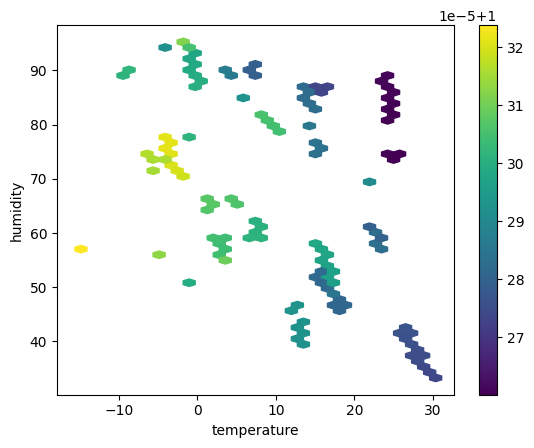

In [ ]:
## Graph temperature with humidity du to refractive index
ax = dist_df.plot.hexbin(x = 'temperature',
                        y = 'humidity',
                        C = 'refractive index',
                        reduce_C_function=np.mean,
                        gridsize=(30,30),
                        cmap='viridis')

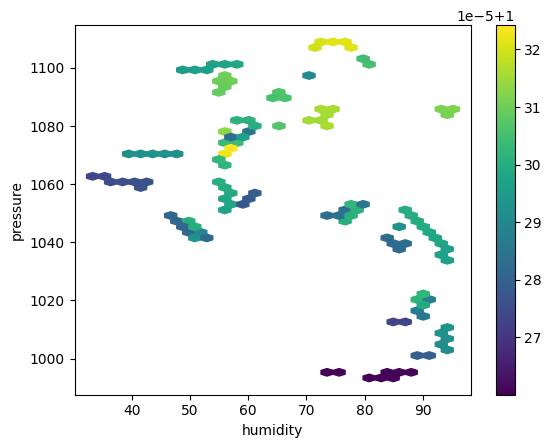

In [258]:
## Graph distance with refractive index du to ppm correction
ax = dist_df.plot.hexbin(x = 'humidity',
                        y = 'pressure',
                        C = 'refractive index',
                        reduce_C_function=np.mean,
                        gridsize=(30,30),
                        cmap='viridis')

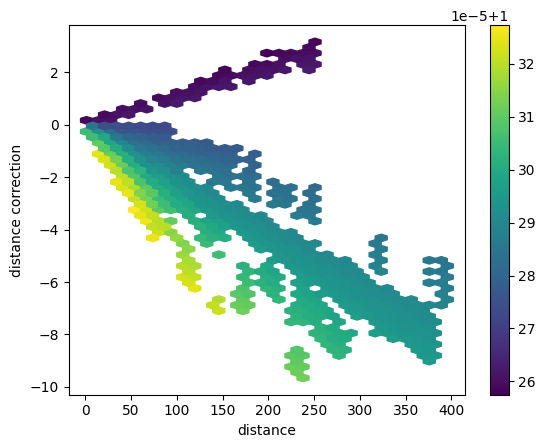

In [269]:
## Graph distance with distance correction (mm) du to refractive index
ax = dist_df.plot.hexbin(x = 'distance',
                        y = 'distance correction',
                        C = 'refractive index',
                        reduce_C_function=np.mean,
                        gridsize=(30,30),
                        cmap='viridis')

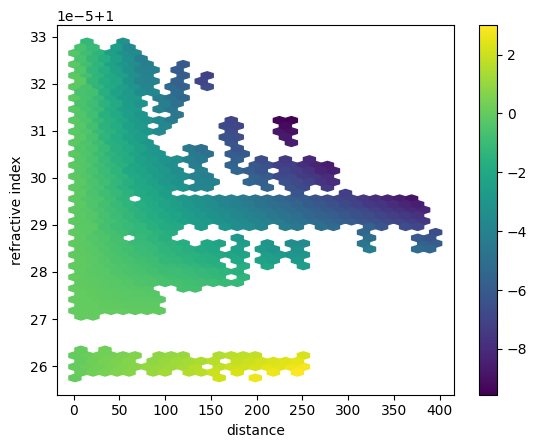

In [270]:
## Graph distance with distance correction du to refractive index
ax = dist_df.plot.hexbin(x = 'distance',
                        y = 'refractive index',
                        C = 'distance correction',
                        reduce_C_function=np.mean,
                        gridsize=(30,30),
                        cmap='viridis')

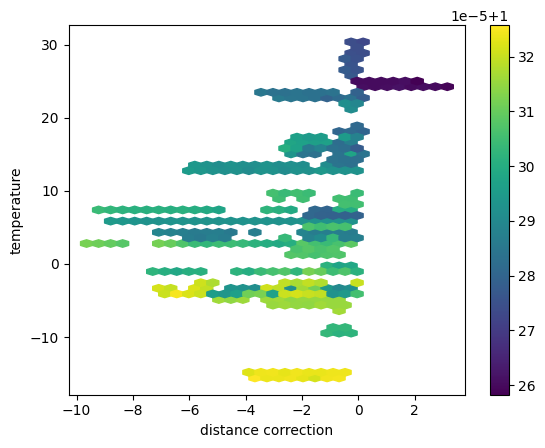

In [12]:
## Graph distance with distance correction du to refractive index
ax = dist_df.plot.hexbin(x = 'distance correction',
                        y = 'temperature',
                        C = 'refractive index',
                        reduce_C_function=np.mean,
                        gridsize=(30,30),
                        cmap='viridis')